### Load libraries needed

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from matplotlib import gridspec
from scipy.stats import pearsonr
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

In [2]:
class PartialCCA(BaseEstimator, TransformerMixin):

    # Joaquin Gonzalez, Buzsaki lab, Chen Lab.
    
    def __init__(self, regularization=1e-3):
        self.regularization = regularization

    def fit(self, X, Y, Z = None, verbose=True):

        """
        Computes Partial Canonical Correlation Analysis (pCCA) using eigenvalue decomposition
        based on sklearn's cross decomposition approach. Aims to extract eigenvectors
        corresponding to CCA weights for datax and datay from the m_matrix.
    
        Args:
            datax (numpy.ndarray): Data array X of shape (n_samples, n_features_x).
            datay (numpy.ndarray): Data array Y of shape (n_samples, n_features_y).
            dataz (numpy.ndarray): Conditional data array Z of shape (n_samples, n_features_z).
            regularization (float, optional): Regularization parameter. Defaults to 1e-6.
    
        Returns:
            tuple: A tuple containing:
                - canonical_correlations (numpy.ndarray): Real-valued canonical correlations, shape (min(n_features_x, n_features_y),).
                - wx (numpy.ndarray): Real-valued canonical weights for datax, shape (n_features_x, min(n_features_x, n_features_y)).
                - wy (numpy.ndarray): Real-valued canonical weights for datay, shape (n_features_y, min(n_features_x, n_features_y)).
                           Returns empty arrays if there are issues in computation.
        """

        # default to regular CCA if z is not provided  
        if Z is None:
            if verbose:
                print("The variable Z is not provided for partial CCA, defaulting to regular CCA.")
            n_samples = X.shape[0]
            X_resid = X
            Y_resid = Y
            
        else:
            n_samples = X.shape[0]
            ZTZ_inv = np.linalg.pinv(Z.T @ Z)
            self.X_beta_ = ZTZ_inv @ Z.T @ X
            self.Y_beta_ = ZTZ_inv @ Z.T @ Y
    
            X_resid = X - Z @ self.X_beta_
            Y_resid = Y - Z @ self.Y_beta_
            self.X_resid_ = X - Z @ self.X_beta_
            self.Y_resid_ = Y - Z @ self.Y_beta_

        sigma_xx = (X_resid.T @ X_resid) / (n_samples - 1)
        sigma_yy = (Y_resid.T @ Y_resid) / (n_samples - 1)
        sigma_xy = (X_resid.T @ Y_resid) / (n_samples - 1)
        sigma_yx = sigma_xy.T

        sigma_xx += self.regularization * np.eye(X.shape[1])
        sigma_yy += self.regularization * np.eye(Y.shape[1])

        sigma_xx_inv = np.linalg.pinv(sigma_xx)
        sigma_yy_inv = np.linalg.pinv(sigma_yy)

        m = sigma_xx_inv @ sigma_xy @ sigma_yy_inv @ sigma_yx
        eigvals, eigvecs_x = np.linalg.eig(m)

        canonical_corrs_sq = np.clip(np.real(eigvals), 0, None)
        canonical_corrs = np.sqrt(canonical_corrs_sq)
        sorted_idx = np.argsort(canonical_corrs)[::-1]

        n_components = min(X_resid.shape[1], Y_resid.shape[1])
        self.canonical_correlations_ = canonical_corrs[sorted_idx][:n_components]
        self.weights_x_ = np.real(eigvecs_x[:, sorted_idx][:, :n_components])
        self.weights_x_ /= np.linalg.norm(self.weights_x_, axis=0, keepdims=True)
        
        self.weights_y_ = np.linalg.solve(sigma_yy, sigma_yx @ self.weights_x_)
        self.weights_y_ = np.real(self.weights_y_)
        self.weights_y_ /= np.linalg.norm(self.weights_y_, axis=0, keepdims=True)

        return self

    def transform(self, X, Y):
        projections_x = []
        projections_y = []
        for i in range(self.weights_x_.shape[1]):
            # Custom projection: weighted sum across neurons (features) at each time point
            proj_x = np.nansum(X.T * self.weights_x_[:, i][:, np.newaxis], axis=0)
            proj_y = np.nansum(Y.T * self.weights_y_[:, i][:, np.newaxis], axis=0)
            projections_x.append(proj_x)
            projections_y.append(proj_y)
        return np.array(projections_x), np.array(projections_y)

    def fit_transform(self, X, Y):
        self.fit(X, Y, Z)
        return self.transform(X, Y)
        
    def score(self, X, Y):
        proj_x, proj_y = self.transform(X, Y)
        return np.array([
            pearsonr(proj_x[i], proj_y[i])[0]
            for i in range(proj_x.shape[0])
        ])

    def surrogate_test(self, X, Y, Z = None, n_surrogates = 100):    
        # perform surrogates based on randomly circularly shifting one population and keeping the other two the same
        r_real = self.canonical_correlations_
        r_surr = []    
        if Z is None:
            print("The variable Z is not provided for partial CCA, defaulting to regular CCA.")
            
        for surrogates in range(n_surrogates):
            shift_val = np.random.randint(1, X.shape[0])
            X_roll = np.roll(X,shift = shift_val,axis = 0) # circular shift
            temp_model = PartialCCA()
            if Z is None:
                temp_model.fit(X_roll, Y, verbose = False)
            else:
                temp_model.fit(X_roll, Y, Z)
            r = temp_model.canonical_correlations_[0]
            r_surr.append(r)

        p_value = []
        for comp in r_real:
            p_value.append(np.sum(r_surr>comp)/n_surrogates)
        return p_value, r_surr

### Load population recordings
#### Already preprocessed and filter by speed (>2.5 cm)

In [3]:
import os

name = 'TES_sResp_M02_20240313'
directory = "/gpfs/home/gonzaj81/datasets/Misi/"
os.chdir(directory+name)

example_recording = np.load('Example_recording_ca3_ca1_rsc.npz')
ca1 = example_recording['conv_neurons_ca1_speed']
ca3 = example_recording['conv_neurons_ca3_speed']
rsc = example_recording['conv_neurons_rsc_speed']
position = example_recording['linearized_position_speed']

srate = 1250

### Plot data

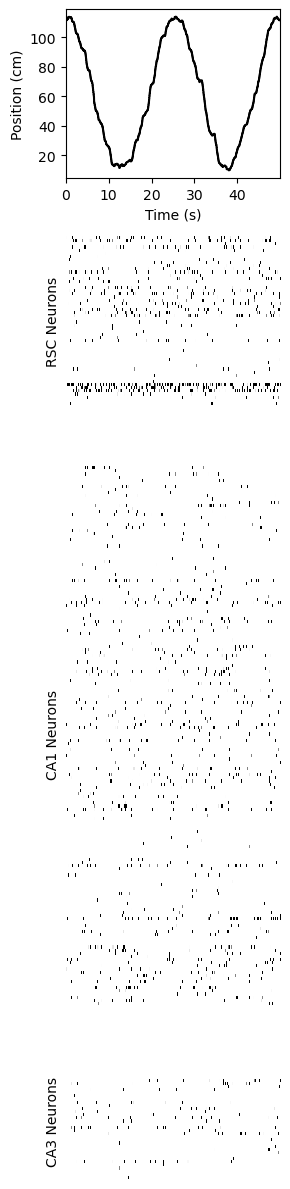

In [4]:
plt.figure(figsize = (3,12))

gs = gridspec.GridSpec(4, 1, height_ratios = (rsc.shape[0],rsc.shape[0],ca1.shape[0],ca3.shape[0]))

lenght = srate*50
start = 10000
window = np.arange(start, start+lenght)
time = np.arange(0,lenght)/srate


plt.subplot(gs[0])
plt.plot(time,position[window], color = 'black')
plt.xlim([0,time[-1]])
plt.ylabel('Position (cm)')
plt.xlabel('Time (s)')

plt.subplot(gs[1])
plt.imshow(rsc[:,window], vmin = 0, vmax = 1, cmap = 'Greys', aspect = 'auto', interpolation = 'nearest')
plt.ylabel('RSC Neurons')
plt.box(False)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[2])
plt.imshow(ca1[:,window], vmin = 0, vmax = 1, cmap = 'Greys', aspect = 'auto', interpolation = 'nearest')
plt.ylabel('CA1 Neurons')
plt.box(False)
plt.xticks([])
plt.yticks([])

plt.subplot(gs[3])
plt.imshow(ca3[:,window], vmin = 0, vmax = 1, cmap = 'Greys', aspect = 'auto', interpolation = 'nearest')
plt.ylabel('CA3 Neurons')
plt.box(False)
plt.xticks([])
plt.yticks([])

plt.tight_layout()

### Z-score data

In [5]:
# z-score data

# --- Handle constant rows BEFORE z-scoring ---
def remove_constant_rows(data):
    """Removes rows with zero standard deviation from a 2D numpy array."""
    stds = np.std(data, axis=1)
    non_constant_rows = stds > 0
    return data[non_constant_rows, :], non_constant_rows # return filtered data and boolean mask

ca1, mask_ca1 = remove_constant_rows(ca1)
ca3, mask_ca3 = remove_constant_rows(ca3)
rsc, mask_rsc = remove_constant_rows(rsc)

# --- Now perform z-scoring AFTER removing constant rows ---
ca1_z = stats.zscore(ca1,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
ca3_z = stats.zscore(ca3,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness
rsc_z = stats.zscore(rsc,axis = 1, nan_policy='omit') # Added nan_policy='omit' for robustness

### Compute pCCA between CA1 and CA3, conditioned on RSC

In [6]:
# fit pCCA
ca1_ca3_pCCA = PartialCCA()
ca1_ca3_pCCA.fit(ca1_z.T,ca3_z.T,rsc_z.T)

# get correlations
correlations_ca1_ca3 = ca1_ca3_pCCA.canonical_correlations_

# Access weights
ca1_weights_ca1_ca3 = ca1_ca3_pCCA.weights_x_
ca3_weights_ca1_ca3 = ca1_ca3_pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
ca1_ca3_p_values,ca1_ca3_r_surr = ca1_ca3_pCCA.surrogate_test(ca1_z.T,ca3_z.T,rsc_z.T)

### Compute pCCA between CA1 and RSC, conditioned on CA3

In [7]:
# fit pCCA
ca1_rsc_pCCA = PartialCCA()
ca1_rsc_pCCA.fit(ca1_z.T,rsc_z.T,ca3_z.T)

# get correlations
correlations_ca1_rsc = ca1_rsc_pCCA.canonical_correlations_

# Access weights
ca1_weights_ca1_rsc = ca1_rsc_pCCA.weights_x_
rsc_weights_ca1_rsc = ca1_rsc_pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
ca1_rsc_p_values,ca1_rsc_r_surr = ca1_rsc_pCCA.surrogate_test(ca1_z.T,rsc_z.T,ca3_z.T)

### Compute pCCA between CA3 and RSC, conditioned on CA1

In [14]:
# fit pCCA
ca3_rsc_pCCA = PartialCCA()
ca3_rsc_pCCA.fit(ca3_z.T,rsc_z.T,ca1_z.T)

# get correlations
correlations_ca3_rsc = ca3_rsc_pCCA.canonical_correlations_

# Access weights
ca3_weights_ca3_rsc = ca3_rsc_pCCA.weights_x_
rsc_weights_ca3_rsc = ca3_rsc_pCCA.weights_y_

# get pvalues for each pCCA subspace based on surrogates
ca3_rsc_p_values,ca3_rsc_r_surr = ca3_rsc_pCCA.surrogate_test(ca3_z.T,rsc_z.T,ca1_z.T)

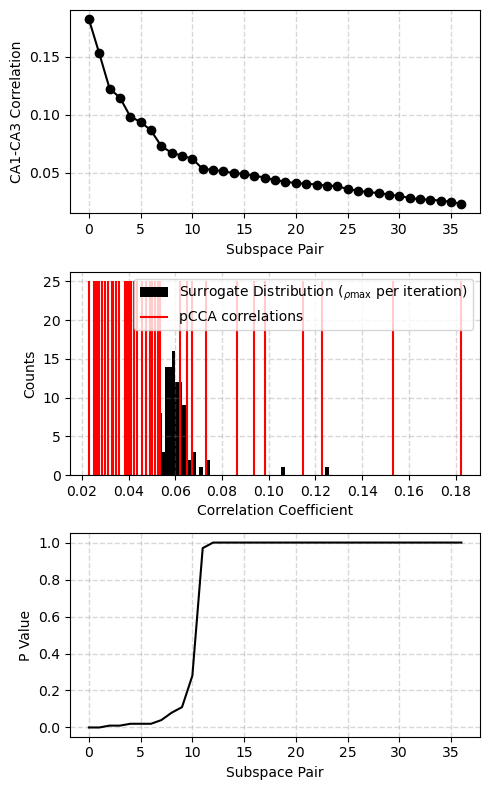

In [9]:
plt.figure(figsize = (5,8))

plt.subplot(311)
plt.plot(correlations_ca1_ca3,'-o', color = 'black')
plt.ylabel('CA1-CA3 Correlation')
plt.xlabel('Subspace Pair')
#plt.ylim([-0.1,1])
#plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(312)
plt.hist(ca1_ca3_r_surr, color='black', bins = 50, label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.vlines(correlations_ca1_ca3,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(313)
plt.plot(ca1_ca3_p_values, color='black')
plt.xlabel('Subspace Pair')
plt.ylabel('P Value')
#plt.hlines(0,len(ca1_ca3_p_values),0.05, color = 'red')
#plt.yscale('log')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()

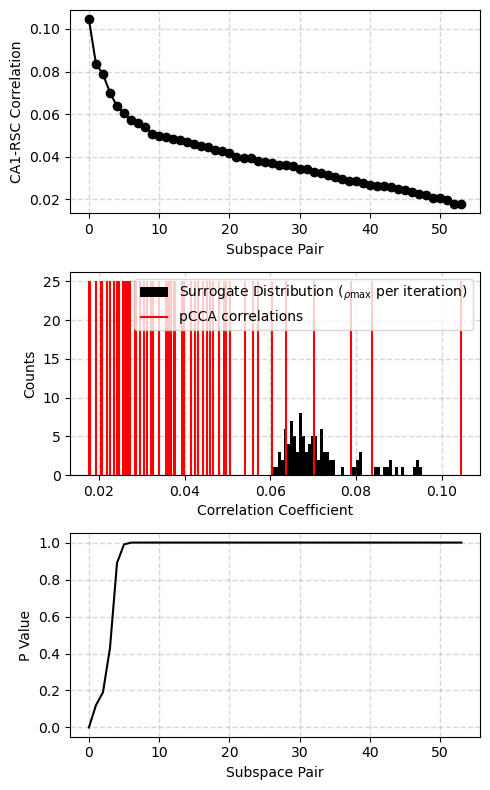

In [11]:
plt.figure(figsize = (5,8))

plt.subplot(311)
plt.plot(correlations_ca1_rsc,'-o', color = 'black')
plt.ylabel('CA1-RSC Correlation')
plt.xlabel('Subspace Pair')
#plt.ylim([-0.1,1])
#plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(312)
plt.hist(ca1_rsc_r_surr, color='black', bins = 50, label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.vlines(correlations_ca1_rsc,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(313)
plt.plot(ca1_rsc_p_values, color='black')
plt.xlabel('Subspace Pair')
plt.ylabel('P Value')
#plt.hlines(0,len(ca1_ca3_p_values),0.05, color = 'red')
#plt.yscale('log')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()

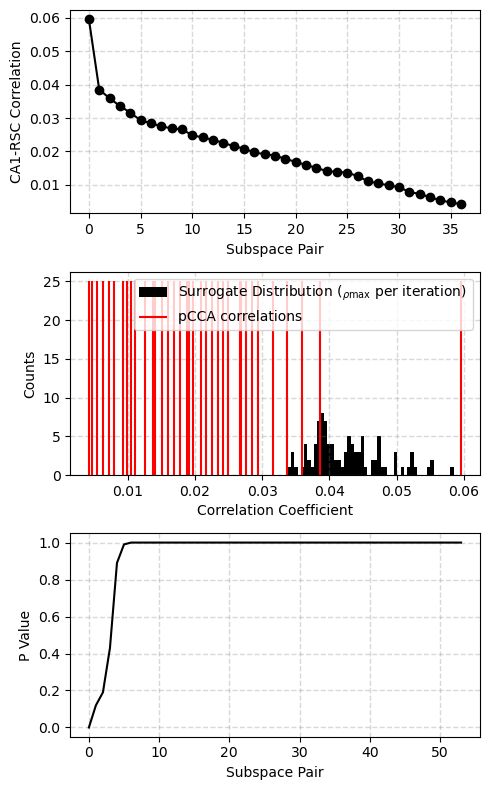

In [15]:
plt.figure(figsize = (5,8))

plt.subplot(311)
plt.plot(correlations_ca3_rsc,'-o', color = 'black')
plt.ylabel('CA1-RSC Correlation')
plt.xlabel('Subspace Pair')
#plt.ylim([-0.1,1])
#plt.yticks(np.arange(0,1.1,0.5))
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(312)
plt.hist(ca3_rsc_r_surr, color='black', bins = 50, label=r'Surrogate Distribution ($_{\rho\max}$ per iteration)')
plt.vlines(correlations_ca3_rsc,0,25, color = 'red', label = 'pCCA correlations')
plt.xlabel('Correlation Coefficient')
plt.legend()
plt.ylabel('Counts')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.subplot(313)
plt.plot(ca1_rsc_p_values, color='black')
plt.xlabel('Subspace Pair')
plt.ylabel('P Value')
#plt.hlines(0,len(ca1_ca3_p_values),0.05, color = 'red')
#plt.yscale('log')
plt.grid(color='grey', linestyle='--', linewidth=1 ,alpha = 0.3, axis = 'both')

plt.tight_layout()